In [1]:
!pip install kagglehub torch torchvision torchaudio pytorch-lightning transformers timm pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 55.1 MB/s eta 0:00:00


In [2]:
import kagglehub
import os
import random
import shutil

# Download dataset
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")
print("Path to dataset files:", path)


100%|██████████| 1.76G/1.76G [01:20<00:00, 23.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1


In [9]:
import kagglehub
import os
import shutil
import random
from pathlib import Path

# Step 1: Download dataset using kagglehub
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")
print(f"Path to dataset files: {path}")

# Step 2: Define dataset paths and directory for organized structure
dataset_path = Path(path) / "lung_colon_image_set"
split_base_dir = Path("/content/split_dataset")  # Update the path if necessary
split_base_dir.mkdir(parents=True, exist_ok=True)

# Class folders based on actual folder names in the dataset
class_folders = {
    'lung_aca': dataset_path / 'lung_image_sets' / 'lung_aca',     # Lung adenocarcinoma
    'lung_n': dataset_path / 'lung_image_sets' / 'lung_n',         # Lung benign
    'lung_scc': dataset_path / 'lung_image_sets' / 'lung_scc',     # Lung squamous cell carcinoma
    'colon_aca': dataset_path / 'colon_image_sets' / 'colon_aca',  # Colon adenocarcinoma
    'colon_n': dataset_path / 'colon_image_sets' / 'colon_n'       # Colon benign
}

# Step 3: Create train, test, val directories with subfolders for each class
for split in ['train', 'test', 'val']:
    for class_name in class_folders.keys():
        (split_base_dir / split / class_name).mkdir(parents=True, exist_ok=True)

# Step 4: Organize images by splitting the complete dataset into 60% train, 30% test, and 10% val
for class_name, folder_path in class_folders.items():
    if folder_path.exists():
        # Collect and shuffle all the images from the class folder
        image_files = list(folder_path.glob("*.*"))  # Adjust file extensions if needed
        random.shuffle(image_files)  # Shuffle the images for random splitting

        # Calculate the number of images for each split (train, test, val)
        train_count = int(0.6 * len(image_files))
        test_count = int(0.3 * len(image_files))

        train_images = image_files[:train_count]
        test_images = image_files[train_count:train_count + test_count]
        val_images = image_files[train_count + test_count:]

        # Move images into train, test, and val directories
        for img_file in train_images:
            shutil.copy(img_file, split_base_dir / 'train' / class_name / img_file.name)
        for img_file in test_images:
            shutil.copy(img_file, split_base_dir / 'test' / class_name / img_file.name)
        for img_file in val_images:
            shutil.copy(img_file, split_base_dir / 'val' / class_name / img_file.name)

        print(f"Processed {class_name}: {len(train_images)} train, {len(test_images)} test, {len(val_images)} val images.")
    else:
        print(f"Warning: Folder for '{class_name}' does not exist!")


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1
Processed lung_aca: 3000 train, 1500 test, 500 val images.
Processed lung_n: 3000 train, 1500 test, 500 val images.
Processed lung_scc: 3000 train, 1500 test, 500 val images.
Processed colon_aca: 3000 train, 1500 test, 500 val images.
Processed colon_n: 3000 train, 1500 test, 500 val images.


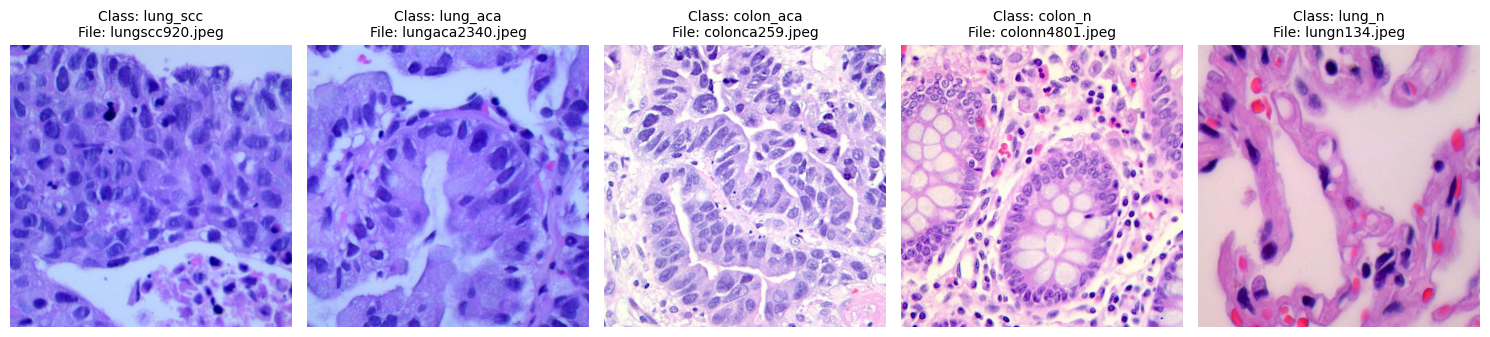

In [10]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Define the path to the organized dataset
dataset_path = Path("/content/split_dataset/train")  # Update to train, test, or val as needed

# Function to visualize one sample image per class with its name and label
def visualize_samples(dataset_dir, num_samples=1):
    # Get class folders
    class_folders = [f for f in dataset_dir.iterdir() if f.is_dir()]

    # Set up plot
    fig, axs = plt.subplots(1, len(class_folders), figsize=(15, 5))

    for i, class_folder in enumerate(class_folders):
        # Randomly select an image from each class folder
        image_files = list(class_folder.glob("*.*"))
        if image_files:
            sample_image = random.choice(image_files)  # Choose one image randomly
            img = mpimg.imread(sample_image)

            # Display the image
            axs[i].imshow(img)
            axs[i].axis('off')

            # Set title as image name and class name
            axs[i].set_title(f"Class: {class_folder.name}\nFile: {sample_image.name}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Call the function to visualize samples
visualize_samples(dataset_path)


In [11]:
!pip install timm torch torchvision

In [12]:
import os
import torch
import timm
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths to dataset
data_dir = Path("/content/split_dataset")  # Update this if needed

# Define transformations
img_size = 224  # Resized image dimensions
batch_size = 16

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset using ImageFolder
train_dataset = ImageFolder(data_dir / 'train', transform=transform)
val_dataset = ImageFolder(data_dir / 'val', transform=transform)
test_dataset = ImageFolder(data_dir / 'test', transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Swin Transformer model pre-trained on ImageNet and modify for 5 classes
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=5)
model = model.to(device)

# Freeze initial layers to reduce computation (optional)
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True  # Unfreeze the last layer (head)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)  # Decrease LR by 0.1 every 2 epochs

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5)

# Testing the model
model.eval()
test_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_loader.dataset)
print(f"\nTest Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]


Epoch 1/5
----------


100%|██████████| 938/938 [05:11<00:00,  3.01it/s]


Train Loss: 0.5612 Acc: 0.9024
Val Loss: 0.2395 Acc: 0.9516

Epoch 2/5
----------


100%|██████████| 938/938 [05:14<00:00,  2.98it/s]


Train Loss: 0.2026 Acc: 0.9586
Val Loss: 0.1476 Acc: 0.9640

Epoch 3/5
----------


100%|██████████| 938/938 [05:13<00:00,  3.00it/s]


Train Loss: 0.1594 Acc: 0.9650
Val Loss: 0.1422 Acc: 0.9640

Epoch 4/5
----------


100%|██████████| 938/938 [05:11<00:00,  3.01it/s]


Train Loss: 0.1536 Acc: 0.9649
Val Loss: 0.1368 Acc: 0.9644

Epoch 5/5
----------


100%|██████████| 938/938 [05:14<00:00,  2.98it/s]


Train Loss: 0.1508 Acc: 0.9656
Val Loss: 0.1362 Acc: 0.9648

Test Accuracy: 0.9671


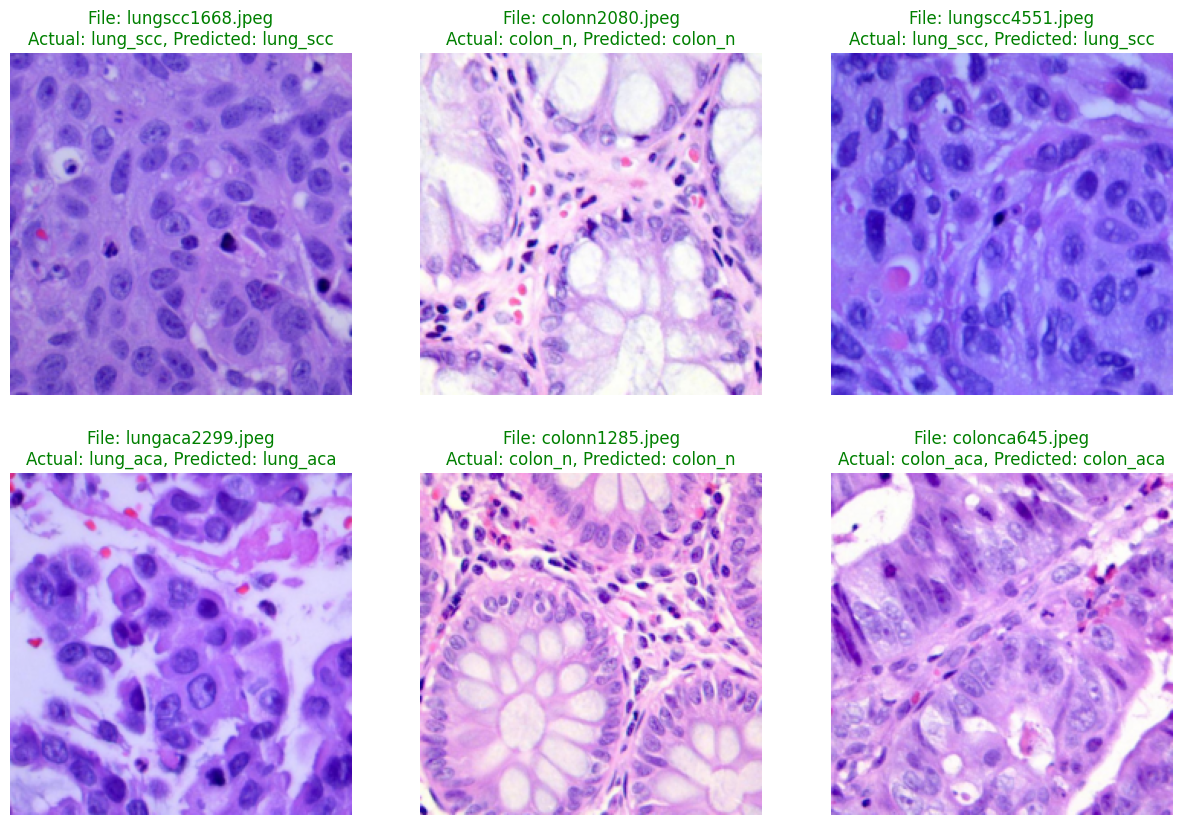

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from pathlib import Path

# Define a transformation to reverse normalization for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# Get class names from the training dataset
class_names = train_dataset.classes

# Function to visualize model predictions on shuffled test images
def visualize_predictions_with_filenames(model, data_loader, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels, paths in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Shuffle samples for more variety
            indices = np.random.permutation(len(inputs))

            for j in indices:
                if images_so_far >= num_images:
                    return

                images_so_far += 1
                ax = plt.subplot(2, 3, images_so_far)
                ax.axis('off')

                # Reverse normalization for display
                img = inv_normalize(inputs[j]).cpu().numpy()
                img = np.transpose(img, (1, 2, 0))  # Convert to HWC format for display

                # Display image
                ax.imshow(img)

                # Retrieve and display the actual filename
                img_filename = Path(paths[j]).name

                # Set title with actual and predicted labels
                actual_class = class_names[labels[j]]
                predicted_class = class_names[preds[j]]
                ax.set_title(f"File: {img_filename}\nActual: {actual_class}, Predicted: {predicted_class}",
                             color=("green" if actual_class == predicted_class else "red"))

# Modify DataLoader to also return image paths
class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        return (*original_tuple, path)

# Load the dataset with image paths
test_dataset_with_paths = ImageFolderWithPaths(data_dir / 'test', transform=transform)
test_loader_with_paths = DataLoader(test_dataset_with_paths, batch_size=batch_size, shuffle=True)

# Call the function to visualize predictions with shuffled test images and filenames
visualize_predictions_with_filenames(model, test_loader_with_paths, num_images=6)
